# Aprendizaje automático y aplicaciones

---
$A^3$ @ FI-UNER : 2021

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
import librosa

from IPython.display import Audio  # widget para reproducción de audio

<div style='background-color:#2BACFF;padding:10px'>
<h1 style='color:#FFFFFF'>Señales</h1>
</div>

NOTA: <a href='https://hgomersall.github.io/pyFFTW/'><b>pyFFTW</b></a> proporciona una implementación más eficiente de la FFT.

**Librerías útiles**

- [scipy](https://docs.scipy.org/doc/)
- [librosa](https://librosa.org/doc/latest/index.html)
- [pywavelet](https://python-speech-features.readthedocs.io/en/latest/)
- [python-speech-features](https://python-speech-features.readthedocs.io/en/latest/)

## OPERACIONES

- [Lectura de datos](#Lectura-de-datos)
- [Filtrado](#Filtrado)
- [Extracción de características](#Extracción-de-características)
- [Otras operaciones comunes](#Otras-operaciones-comunes)

<!--
- FFT
- Oversampling y Subsampling
- Espectrograma
- 
- 
-->

<div style='background-color:#60B6EA;padding:10px'>
<h1 style='color:#FFFFFF'><b>Lectura de datos</b></h1>
</div>

In [2]:
# Subir archivo si se va a ejecutar la notebook en Colab

Audio('open-the-door.wav')

In [3]:
# Leo archivo wav
import scipy.io.wavfile as wavfile

fs, data = wavfile.read('open-the-door.wav', False)  # Frecuencia de muestreo + Amplitud

Ts = 1/fs
N = data.shape[0]
t = np.arange(0,Ts*(N-1),Ts)

data = data.mean(axis=1)

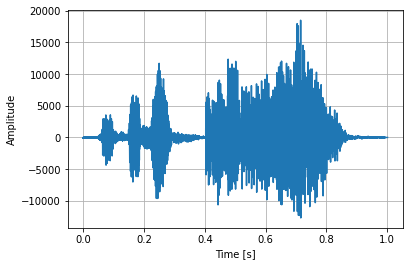

In [4]:
plt.plot(t, data)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude');

In [5]:
from scipy import fftpack

In [6]:
#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(data.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(data)

In [7]:
# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

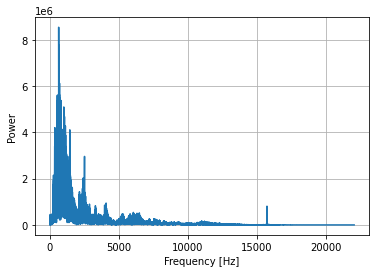

In [8]:
plt.plot(freqs, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.grid(True)

---

In [9]:
import scipy.signal

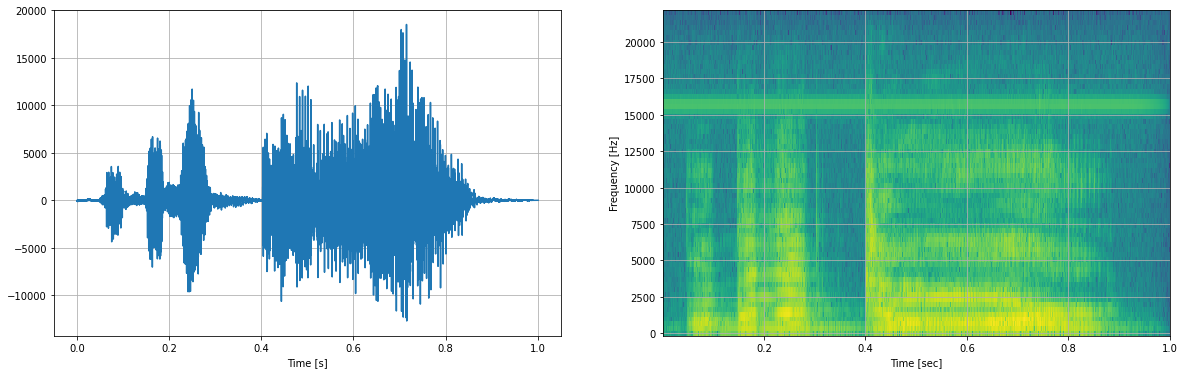

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].plot(t, data, '-C0');
ax[0].grid(True)
ax[0].set_xlabel('Time [s]')


f, t1, Sxx = scipy.signal.spectrogram(data,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
ax[1].grid(True);

## Operaciones útiles - **ventaneo**

In [11]:
frames = librosa.util.frame(data,
                            frame_length=2048,
                            hop_length=64)

In [12]:
frames.shape

(2048, 658)

## Operaciones útiles - **construcción de ventanas**

In [13]:
w = scipy.signal.windows.get_window(window='hanning',
                                    Nx=128,
                                    fftbins=False) # If True (default), create a “periodic” window,
                                                   # ready to use with ifftshift and be multiplied
                                                   # by the result of an FFT (see also fftfreq). --> ver spectrogram
                                                   # If False, create a “symmetric” window, for use
                                                   # in filter design.

128

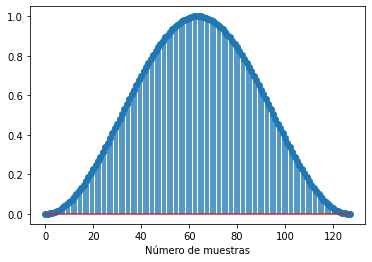

In [14]:
plt.stem(w)
plt.xlabel('Número de muestras');
len(w)

## Operaciones útiles - **submuestreo** y **sobremuestreo**

In [15]:
# SUBMUESTREO
y_8k = librosa.resample(data,
                        orig_sr=fs,
                        target_sr=8000)

In [16]:
print(data.shape,y_8k.shape)

(44145,) (8009,)


In [17]:
# SOBREMUESTREO
y_44k = librosa.resample(y_8k,
                        orig_sr=8000,
                        target_sr=fs)

In [18]:
y_44k.shape

(44150,)

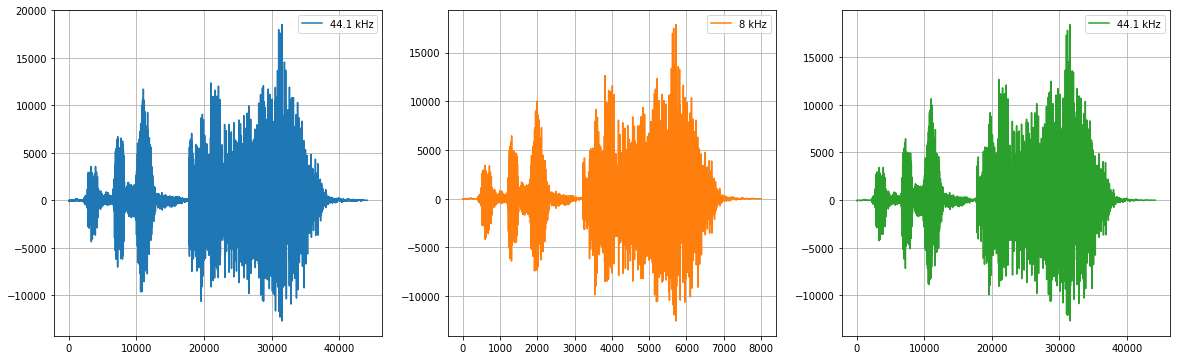

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

ax[0].plot(data, 'C0', label='44.1 kHz')
ax[0].grid(True)
ax[0].legend(loc='best')

ax[1].plot(y_8k, 'C1', label='8 kHz')
ax[1].grid(True)
ax[1].legend(loc='best')

ax[2].plot(y_44k, 'C2', label='44.1 kHz')
ax[2].grid(True)
ax[2].legend(loc='best')

plt.show()

<div style='background-color:#60B6EA;padding:10px'>
<h1 style='color:#FFFFFF'><b>Filtrado</b></h1>
</div>

## FILTRADO DE RUIDO DE LINEA

In [20]:
#!pip install mne

In [21]:
import mne

In [22]:
path = mne.datasets.eegbci.load_data(3, 1)
#path[0]

In [23]:
raw = mne.io.read_raw_edf(path[0], preload=True)

Extracting EDF parameters from /home/mgerard/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


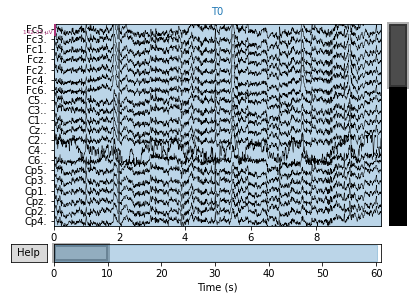

In [24]:
raw.plot(scalings = 'auto');

In [25]:
raw

<RawEDF | S003R01.edf, 64 x 9760 (61.0 s), ~4.8 MB, data loaded>

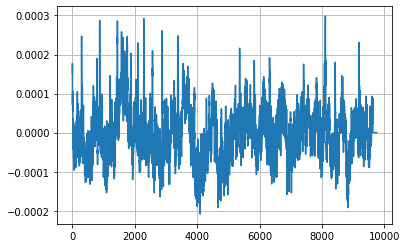

In [26]:
#raw.get_data().shape
ch1 = raw.get_data()[0]

plt.plot(ch1)
plt.grid(True);

In [27]:
# DISEÑO FILTRO NOTCH

w0 = 60   # Hz (frecuencia a remover)
Q = 30    # Dimensionless parameter that characterizes notch filter
          # -3 dB bandwidth bw relative to its center frequency, Q = w0/bw.
fs = 160  # Hz

b, a = scipy.signal.iirnotch(w0=w0,
                             Q=Q,
                             fs=fs)

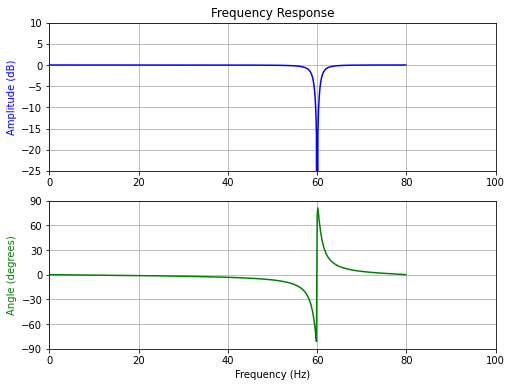

In [28]:
# Frequency response
freq, h = scipy.signal.freqz(b, a, fs=fs)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()

plt.show()

In [29]:
# FILTRO LA SEÑAL

ch1_f = scipy.signal.lfilter(b, a, ch1)

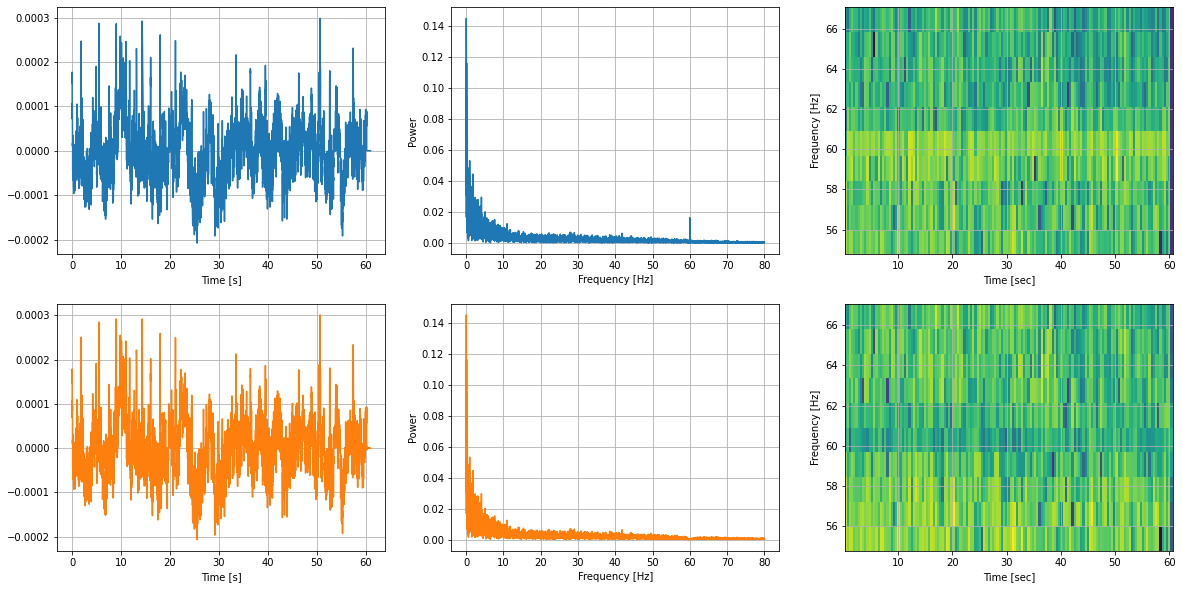

In [30]:
# GRAFICO LOS RESULTADOS

Ts = 1/fs
t = np.arange(0, (Ts * len(ch1)), Ts)

#----------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(20,10))

ax[0,0].plot(t, ch1, '-C0');
ax[0,0].grid(True)
ax[0,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(ch1.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(ch1)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[0,1].plot(freqs, power, '-C0')
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].set_ylabel('Power')
ax[0,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(ch1,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[0,2].pcolormesh(t1, f[45:55], np.log10(Sxx)[45:55], shading='auto')
ax[0,2].set_ylabel('Frequency [Hz]')
ax[0,2].set_xlabel('Time [sec]')
ax[0,2].grid(True)

#----------------------------------------

ax[1,0].plot(t, ch1_f, '-C1');
ax[1,0].grid(True)
ax[1,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(ch1_f.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(ch1_f)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[1,1].plot(freqs, power, '-C1')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_ylabel('Power')
ax[1,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(ch1_f,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1,2].pcolormesh(t1, f[45:55], np.log10(Sxx)[45:55], shading='auto')
ax[1,2].set_ylabel('Frequency [Hz]')
ax[1,2].set_xlabel('Time [sec]')
ax[1,2].grid(True)

plt.tight_layout;

In [31]:
# raw.notch_filter(60)  # utilidad en mne

## FILTRADO DE RUIDO DE LINEA

In [32]:
# Subir archivo si se va a ejecutar la notebook en Colab

data = np.genfromtxt('ecg_fm360Hz_noise_40-180Hz.txt')  # También se podría cargar usando Pandas

fs = 360

Ts = 1/fs
N = data.shape[0]
t = np.arange(0,Ts*N,Ts)

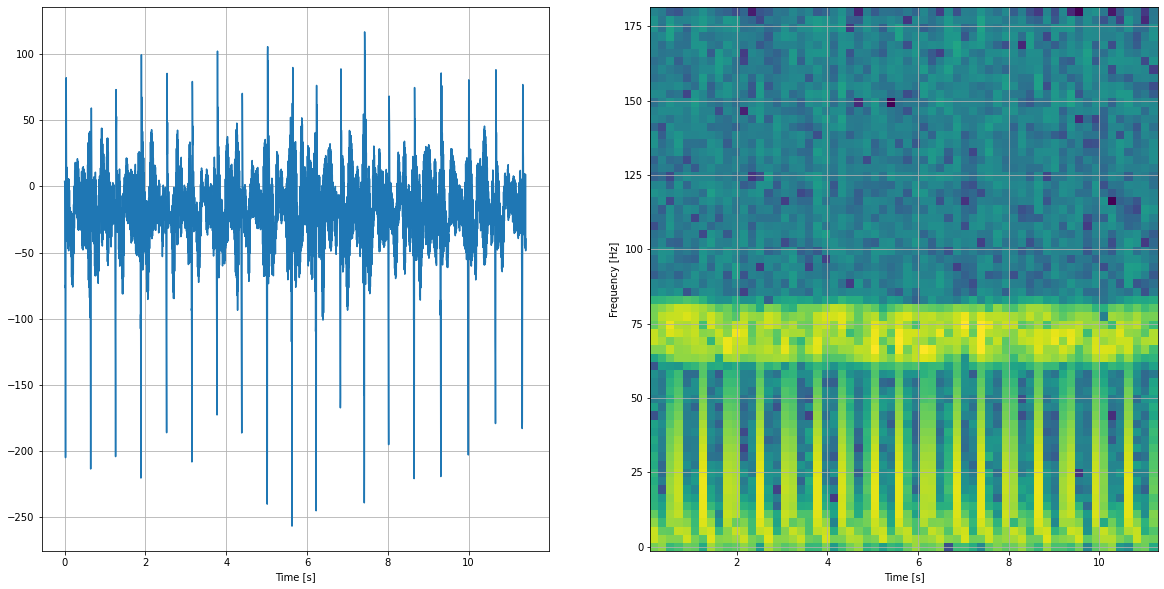

In [33]:
Ts = 1/fs
t = np.arange(0, (Ts * len(data)), Ts)

#----------------------------------------

fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(t, data, '-C0');
ax[0].grid(True)
ax[0].set_xlabel('Time [s]')


f, t1, Sxx = scipy.signal.spectrogram(data,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [s]')
ax[1].grid(True)

**Filtro pasa bajo (40 Hz)**

In [34]:
nyq = 0.5 * fs

f_nyq = fs/2  # Frecuencia Nyquist

### Butterworth

In [35]:
# Busco el orden del filtro de acuerdo a las especificaciones

wp = 35  # Hz

order, wn = scipy.signal.buttord(wp=wp,     # Banda de paso
                                 ws=45,  # Banda de rechazo
                                 gpass=3,   # Atenuación de 3 dB en banda de paso
                                 gstop=60,  # Atenuación de 60 dB en banda de stop
                                 analog=False,  # Digital
                                 fs=fs)

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

Orden: 26
Banda de paso (especificada [normalizada]) --> wp: 35
Banda de paso (calculada)                  --> wn: 0.19446111888709114 (35.00300139967641)


In [36]:
# DISEÑO EL FILTRO
b, a = scipy.signal.butter(order,
                           wn,
                           btype='lowpass',
                           analog=False,
                           fs=fs)  # Frecuencias normalizadas! wn ~ [low high]

### Elíptico

In [37]:
# Busco el orden del filtro de acuerdo a las especificaciones

wp = 40  # Hz

order, wn = scipy.signal.ellipord(wp=wp,   # Banda de paso
                                  ws=42.5,  # Banda de rechazo
                                  gpass=3,   # Atenuación de 3 dB en banda de paso
                                  gstop=60,  # Atenuación de 60 dB en banda de stop
                                  analog=False,  # Digital
                                  fs=fs)

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

Orden: 9
Banda de paso (especificada [normalizada]) --> wp: 40
Banda de paso (calculada)                  --> wn: 0.2222222222222222 (40.0)


In [38]:
# DISEÑO EL FILTRO
b, a = scipy.signal.ellip(N=order,
                          rp=1,
                          rs=60,
                          Wn=wn,
                          btype='lowpass',
                          analog=False,
                          fs=fs)  # Frecuencias normalizadas! wn ~ [low high]

---

In [39]:
# FILTRO LA SEÑAL
y = scipy.signal.lfilter(b, a, data)  # Aplico el filtro a la señal

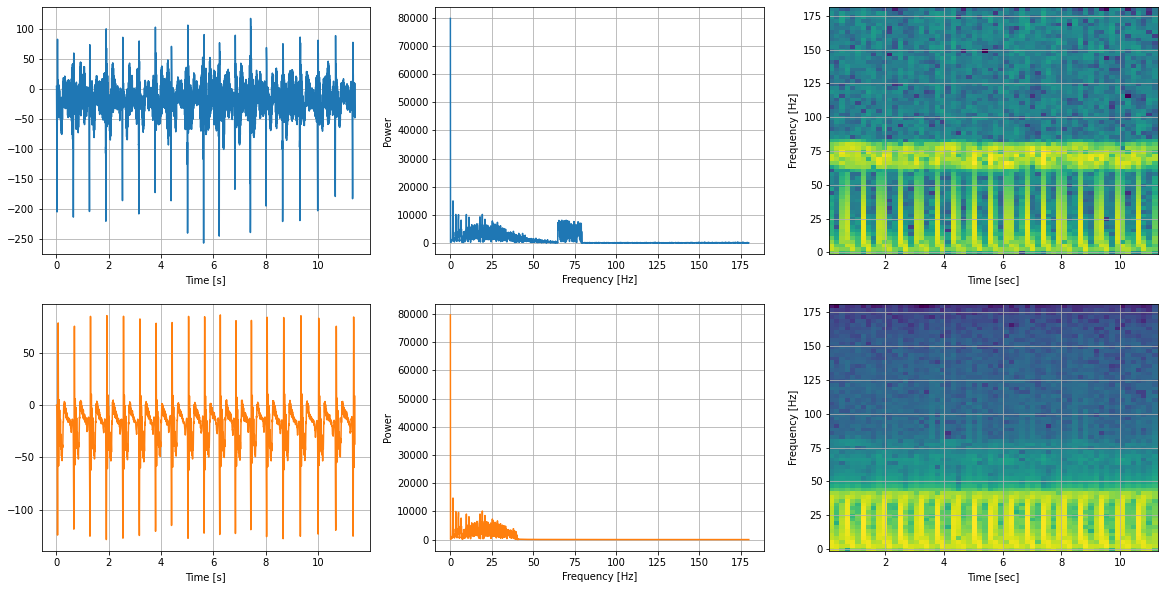

In [40]:
# GRAFICO LOS RESULTADOS

fig, ax = plt.subplots(2, 3, figsize=(20,10))

ax[0,0].plot(t, data, '-C0');
ax[0,0].grid(True)
ax[0,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(data.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(data)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[0,1].plot(freqs, power, '-C0')
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].set_ylabel('Power')
ax[0,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(data,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[0,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[0,2].set_ylabel('Frequency [Hz]')
ax[0,2].set_xlabel('Time [sec]')
ax[0,2].grid(True)

#----------------------------------------

ax[1,0].plot(t, y, '-C1');
ax[1,0].grid(True)
ax[1,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(y.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(y)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[1,1].plot(freqs, power, '-C1')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_ylabel('Power')
ax[1,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(y,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[1,2].set_ylabel('Frequency [Hz]')
ax[1,2].set_xlabel('Time [sec]')
ax[1,2].grid(True)

plt.tight_layout;

---

## FILTRADO DE FRECUENCIAS en señal de audio

In [41]:
# Subir archivo si se va a ejecutar la notebook en Colab

import scipy.io.wavfile as wavfile

fs, data = wavfile.read('open-the-door.wav', False)  # Frecuencia de muestreo + Amplitud

Ts = 1/fs
N = data.shape[0]
t = np.arange(0,Ts*(N-1),Ts)

data = data.mean(axis=1)

**Filtro pasa bajo (1000 Hz)**

In [42]:
# Sample rate and desired cutoff frequencies (in Hz).
wp = 1000.0  # Hz

nyq = 0.5 * fs
high = wp / nyq  # Normalizo frecuencia

f_nyq = fs/2  # Frecuencia Nyquist

### Butterworth

In [43]:
# Busco el orden del filtro de acuerdo a las especificaciones

order, wn = scipy.signal.buttord(wp=wp,     # Banda de paso
                                 ws=1.1 * wp,  # Banda de rechazo
                                 gpass=3,   # Atenuación de 3 dB en banda de paso
                                 gstop=60,  # Atenuación de 60 dB en banda de stop
                                 analog=False,  # Digital
                                 fs=fs)

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

Orden: 73
Banda de paso (especificada [normalizada]) --> wp: 1000.0
Banda de paso (calculada)                  --> wn: 0.0453529441087093 (1000.03241759704)


In [44]:
# DISEÑO EL FILTRO
b, a = scipy.signal.butter(order,
                           wn,
                           btype='lowpass',
                           analog=False,
                           fs=fs)  # Frecuencias normalizadas! wn ~ [low high]

### Elíptico

In [45]:
# Busco el orden del filtro de acuerdo a las especificaciones

order, wn = scipy.signal.ellipord(wp=wp,   # Banda de paso
                                  ws=1.1*wp,  # Banda de rechazo
                                  gpass=3,   # Atenuación de 3 dB en banda de paso
                                  gstop=60,  # Atenuación de 60 dB en banda de stop
                                  analog=False,  # Digital
                                  fs=fs)

print('Orden: {}'.format(order))
print('Banda de paso (especificada [normalizada]) --> wp: {}'.format(wp))
print('Banda de paso (calculada)                  --> wn: {} ({})'.format(wn/f_nyq, wn))

Orden: 8
Banda de paso (especificada [normalizada]) --> wp: 1000.0
Banda de paso (calculada)                  --> wn: 0.04535147392290249 (999.9999999999999)


In [46]:
# DISEÑO EL FILTRO
b, a = scipy.signal.ellip(N=order,
                          rp=1,
                          rs=60,
                          Wn=wn,
                          btype='lowpass',
                          analog=False,
                          fs=fs)  # Frecuencias normalizadas! wn ~ [low high]

---

In [47]:
# FILTRO LA SEÑAL
y = scipy.signal.lfilter(b, a, data)  # Aplico el filtro a la señal

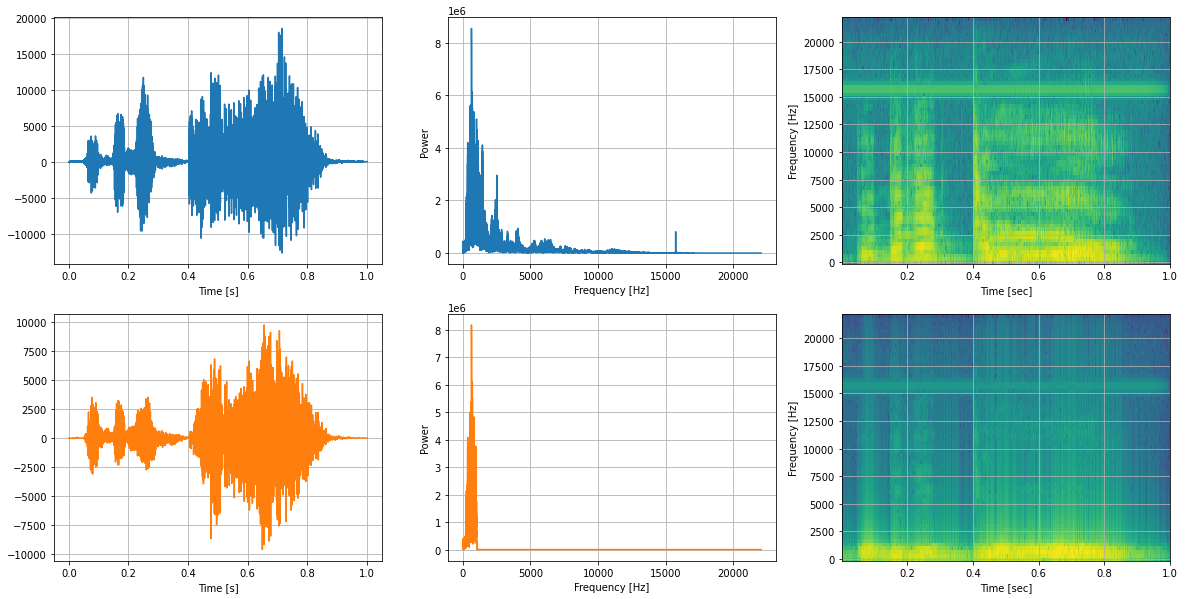

In [48]:
# GRAFICO LOS RESULTADOS

fig, ax = plt.subplots(2, 3, figsize=(20,10))

ax[0,0].plot(t, data, '-C0');
ax[0,0].grid(True)
ax[0,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(data.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(data)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[0,1].plot(freqs, power, '-C0')
ax[0,1].set_xlabel('Frequency [Hz]')
ax[0,1].set_ylabel('Power')
ax[0,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(data,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[0,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[0,2].set_ylabel('Frequency [Hz]')
ax[0,2].set_xlabel('Time [sec]')
ax[0,2].grid(True)

#----------------------------------------

ax[1,0].plot(t, y, '-C1');
ax[1,0].grid(True)
ax[1,0].set_xlabel('Time [s]')

#----------------------------------------

#La función scipy.fftpack.fftfreq() genera las frecuencias de muestreo
sample_freq = fftpack.fftfreq(y.size, d=1/fs)

# scipy.fftpack.fft() calcula la transformada rápida de Fourier
sig_fft = fftpack.fft(y)

# Debido a que la potencia resultante es simétrica, sólo la parte positiva
# del espectro es utilizada para encontrar la frecuencia

idxs = np.where(sample_freq >= 0)

freqs = sample_freq[idxs]

power = np.abs(sig_fft)[idxs]

ax[1,1].plot(freqs, power, '-C1')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_ylabel('Power')
ax[1,1].grid(True)

#----------------------------------------

f, t1, Sxx = scipy.signal.spectrogram(y,
                                      fs,
                                      window='hanning',
                                      noverlap=65, # Number of points to overlap between segments
                                      nperseg=130,  # Length of each segment
                                      scaling='spectrum')

ax[1,2].pcolormesh(t1, f, 10*np.log10(Sxx), shading='auto')
ax[1,2].set_ylabel('Frequency [Hz]')
ax[1,2].set_xlabel('Time [sec]')
ax[1,2].grid(True)

plt.tight_layout;

In [49]:
# Guardo el archivo de audio

scaled = np.int16(y/np.max(np.abs(y)) * 32767)
scipy.io.wavfile.write('test.wav', 44100, scaled)

In [50]:
Audio('open-the-door.wav')

In [51]:
Audio('test.wav')

<div style='background-color:#60B6EA;padding:10px'>
<h1 style='color:#FFFFFF'><b>Extracción de características</b></h1>
</div>

In [52]:
# Subir archivo si se va a ejecutar la notebook en Colab

import scipy.io.wavfile as wavfile

fs, data = wavfile.read('open-the-door.wav', False)  # Frecuencia de muestreo + Amplitud

Ts = 1/fs
N = data.shape[0]
t = np.arange(0,Ts*(N-1),Ts)

data = data.mean(axis=1)

In [53]:
import librosa

### Zero-crossing

In [54]:
z = librosa.zero_crossings(data)

In [55]:
z

array([ True, False, False, ..., False, False, False])

In [56]:
librosa.util.stack([data, z], axis=-1)

array([[-75.,   1.],
       [-44.,   0.],
       [-15.,   0.],
       ...,
       [  0.,   0.],
       [  0.,   0.],
       [  0.,   0.]])

In [57]:
# Indices donde se produce el cruce por cero
np.nonzero(z)

(array([    0,   114,   115, ..., 44035, 44037, 44038]),)

In [58]:
# Tasa de cruces por cero
zc = librosa.feature.zero_crossing_rate(data,
                                        frame_length=2048,  # Length of the frame over which to compute zero crossing rates
                                        hop_length=512,  # Number of samples to advance for each frame
                                        center=True)  # If True, frames are centered by padding the edges of `y`.

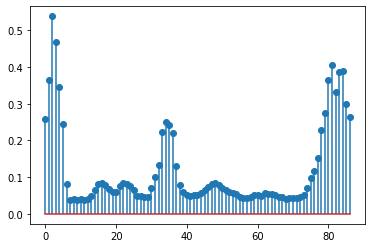

In [59]:
plt.stem(zc.flatten())
plt.show()

---

### MFCC

In [60]:
mfccs = librosa.feature.mfcc(y=data,
                             sr=fs,
                             hop_length=1024,  # 44.1 kHZ --> 23 ms  # 2*y.shape[0],#
                             n_mfcc=13)

In [61]:
mfccs.shape
#y.shape[0]/1024

(13, 44)

[Text(0.5, 1.0, 'MFCC')]

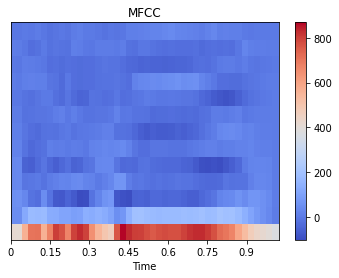

In [62]:
from librosa.display import specshow
fig, ax = plt.subplots()
img = specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

---

## Pitch y F0

In [63]:
# Basado en algoritmo de Yin
f0, voiced_flag, voiced_probs = librosa.pyin(data,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'),
                                             sr=fs)

In [64]:
times = librosa.times_like(f0)  # Inicio de las ventanas temporales

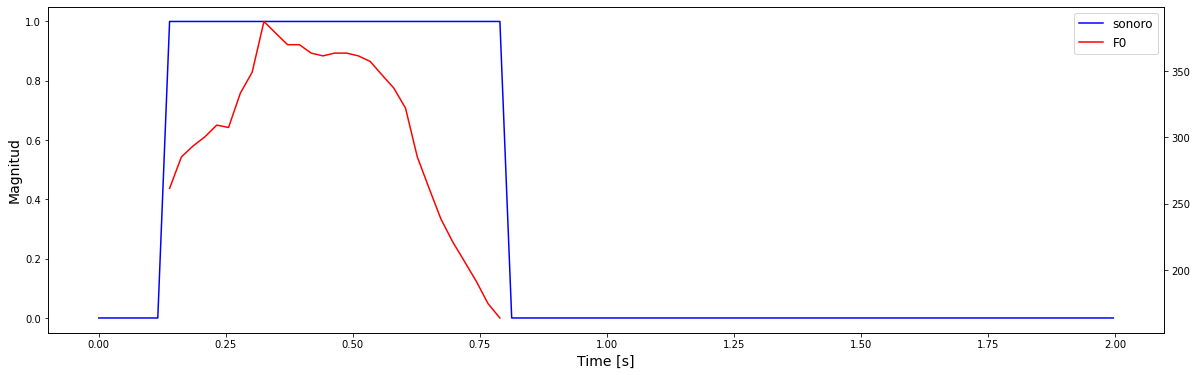

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

ax.plot(times, voiced_flag, '-b', label='sonoro')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(times, f0, '-r', label='F0')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2,
          labels + labels2,
          loc='best',
          fontsize='12')

ax.set_ylabel('Magnitud', fontsize=14)
ax.set_xlabel('Time [s]', fontsize=14)
plt.show();

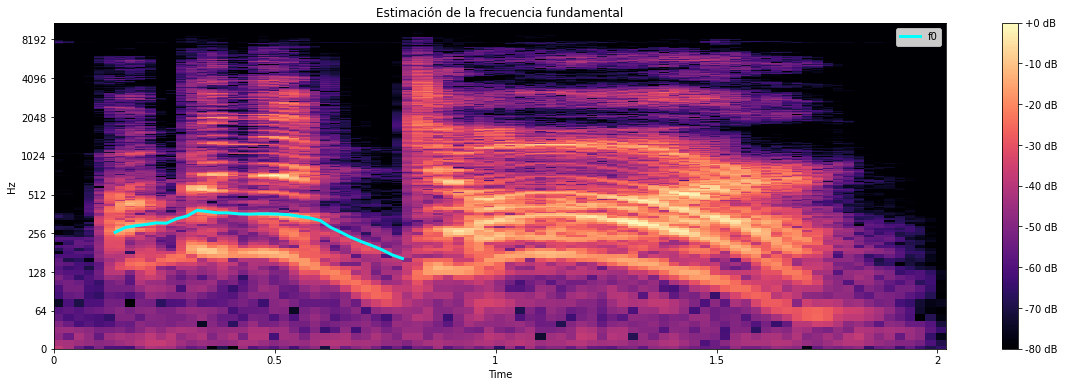

In [66]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)  # Espectrograma

fig, ax = plt.subplots(figsize=(20,6))

img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Estimación de la frecuencia fundamental')
fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.plot(times, f0, label='f0', color='cyan', linewidth=3)

ax.legend(loc='upper right');

## CWT

Otros: https://pywavelets.readthedocs.io/en/latest/index.html

In [67]:
# Subir archivo si se va a ejecutar la notebook en Colab

import scipy.io.wavfile as wavfile

fs, data = wavfile.read('open-the-door.wav', False)  # Frecuencia de muestreo + Amplitud

Ts = 1/fs
N = data.shape[0]
t = np.arange(0,Ts*(N-1),Ts)

data = data.mean(axis=1)

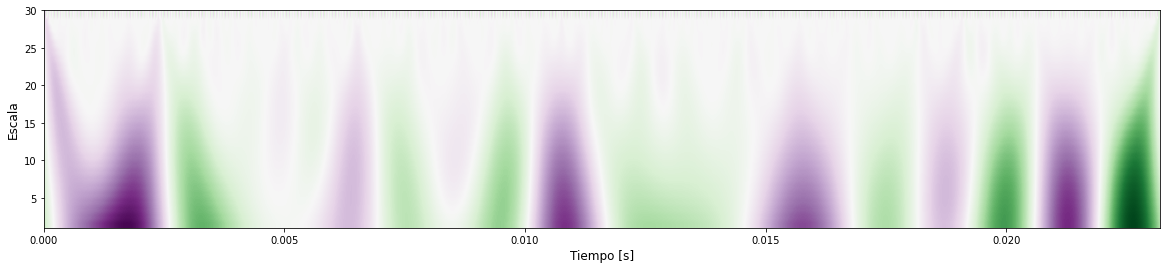

In [68]:
MAX_WIDTH = 30

Nsamples = 1024

cwtmatr = scipy.signal.cwt(data[:Nsamples],
                           widths=np.arange(1, MAX_WIDTH),
                           wavelet=scipy.signal.ricker)

fig, ax = plt.subplots(figsize=(20,4))
ax.imshow(cwtmatr,
          extent=[0, t[:Nsamples].max(), 1, MAX_WIDTH],
          cmap='PRGn',
          aspect='auto',
          vmax=np.abs(cwtmatr).max(),
          vmin=-np.abs(cwtmatr).max())

ax.set_xlabel('Tiempo [s]', fontsize=12)
ax.set_ylabel('Escala', fontsize=12)

plt.show()

<div style='background-color:#60B6EA;padding:10px'>
<h1 style='color:#FFFFFF'><b>Otras operaciones habituales</b></h1>
</div>

## STFT
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html#scipy.signal.stft

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


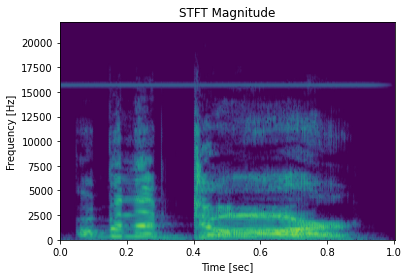

In [69]:
f, t, Zxx = scipy.signal.stft(data,
                              fs=fs,
                              nperseg=256,
                              noverlap=128)

plt.pcolormesh(t,
               f,
               10*np.log10(np.abs(Zxx)),
               vmin=0,
               vmax=np.max(10*np.log10(np.abs(data))),
               shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/usr/lib/python3.6/site-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


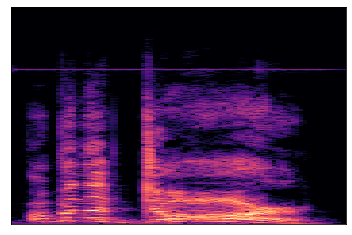

In [70]:
sgram = librosa.stft(data)
librosa.display.specshow(librosa.amplitude_to_db(sgram))